# Data description

* Each row in this data set represents a different product.

* The first 12 columns (Outcome_M1 through Outcome_M12) contains the monthly online sales for the first 12 months after the product launches.  

* Date_1 is the day number the major advertising campaign began and the product launched.  

* Date_2 is the day number the product was announced and a pre-release advertising campaign began.

* Other columns in the data set are features of the product and the advertising campaign.  Quan_x are quantitative variables and Cat_x are categorical variables. Binary categorical variables are measured as (1) if the product had the feature and (0) if it did not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import sklearn.cluster as cluster
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

In [2]:
# Reading the input file
df = pd.read_csv('TrainingDataset[98].csv')
df_copy = df.copy()

In [3]:
df.head()
df.shape

(751, 558)

In [4]:
outcome_list = [col for col in df.columns if 'Outcome' in col]
num_list = [col for col in df.columns if 'Quan' in col]
cat_list = [col for col in df.columns if 'Cat' in col]

## Data Cleaning

In [5]:
#df[num_list].describe()

In [6]:
# Droping columns with zero values
df.drop(columns = ['Quan_26','Quan_29','Quan_30'],axis = 1,inplace = True)

In [7]:
# Checking value counts of categorical columns
# for col in df[cat_list].columns:
#     print('-' * 40 + col + '-' * 40 , end=' - ')
#     display(df[col].value_counts().head(10))

In [8]:
# Droping binary categorical columns with more than 80% values as zero
for col in df[cat_list].columns:
    if np.all(df[col].unique() == [0, 1]):
        if df[col].value_counts()[0] > df.shape[0]*0.8:
            df.drop(columns = col,axis = 1,inplace = True)

**Missing values**

In [9]:
# Droping columns with more than 80% null values
for col in df.columns:
    if df[col].isnull().sum() > df.shape[0]*0.8:
        df.drop(columns = col,axis = 1,inplace = True)

In [10]:
# Droping rows with missing values in Outcome variables
df.dropna(axis=0, subset= outcome_list,inplace = True)

In [11]:
num_list1 = [col for col in df.columns if 'Quan' in col]
cat_list1 = [col for col in df.columns if 'Cat' in col]

In [12]:
# Replacing missing values in Quantitative variables with mean values
for col in df[num_list1].columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mean(),inplace = True)

In [13]:
df.shape

(639, 529)

## EDA

In [14]:
# for col in df[outcome_list].columns:
#     sns.distplot(df[col])
#     plt.show()

In [15]:
# for col in df[num_list1].columns:
#     df.plot(x= col, y='Outcome_M1', kind='scatter')

In [16]:
# corrmat = df[num_list1+outcome_list].corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat,square=True);

## Feature Engineering

In [17]:
# Creating a column to calculate the duration of advertising campaign before product launch
df['Date_Diff'] = df['Date_1'] - df['Date_2']

## Model Buiding

### Clustering

* Creating clusters of products based on the sales curve.
* Using variables Outcome_M[1-12] for creating clusters

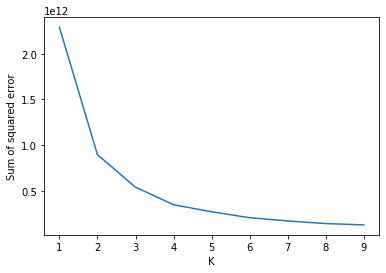

In [18]:
# Elbow plot method
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[outcome_list])
    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [19]:
# Silhouette method
for i in range(3,13):
    labels=cluster.KMeans(n_clusters=i,init="k-means++",random_state=200).fit(df[outcome_list]).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(df[outcome_list],labels,metric="euclidean",random_state=200)))

Silhouette score for k(clusters) = 3 is 0.7875573232107328
Silhouette score for k(clusters) = 4 is 0.7895869189802857
Silhouette score for k(clusters) = 5 is 0.7900584979412495
Silhouette score for k(clusters) = 6 is 0.6289310322233798
Silhouette score for k(clusters) = 7 is 0.5739265124496608
Silhouette score for k(clusters) = 8 is 0.5759776496204891
Silhouette score for k(clusters) = 9 is 0.5746063458420109
Silhouette score for k(clusters) = 10 is 0.5778778311001506
Silhouette score for k(clusters) = 11 is 0.5381604791843158
Silhouette score for k(clusters) = 12 is 0.5381600572790567


In [20]:
# Preprocessing using min max scaler
scaler = MinMaxScaler()
df_outcomes = scaler.fit_transform(df[outcome_list])

In [21]:
# Appying k-means clustering with k = 3
km = KMeans(n_clusters=3)
clusters = km.fit_predict(df_outcomes)

In [22]:
# Appending the cluster column to the original dataframe
df['Cluster'] = clusters

### Classification

**Train-Test Split**

In [23]:
X = df.iloc[:,12:]
y = df.iloc[:,:12]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [24]:
# Train-Test split for classification
X_train_class = X_train.iloc[:,:-1]
X_test_class = X_test.iloc[:,:-1]
y_train_class = X_train['Cluster']
y_test_class = X_test['Cluster']

**Recurrsive Feature Elimination**

In [25]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=40)
rfe.fit(X_train_class, y_train_class)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=40, step=1, verbose=0)

**Random Forest**

In [26]:
forest = RandomForestClassifier(random_state = 0)
forest.fit(rfe.transform(X_train_class), y_train_class)
forest.score(rfe.transform(X_test_class), y_test_class)

0.8984375

**Scaling Numerical Data**

In [27]:
scaler_range = MinMaxScaler()

# Get scaling parameters with the train sample exclusively, using the Scaler.fit() function

scaler_range.fit(X_train_class)

# Scale data using Scaler.transform()

X_train_class_scaled = pd.DataFrame(scaler_range.transform(X_train_class))
X_test_class_scaled = pd.DataFrame(scaler_range.transform(X_test_class))

**Logistic Regression**

In [28]:
logistic = LogisticRegression(random_state = 0)
logistic.fit(rfe.transform(X_train_class_scaled), y_train_class)
logistic.score(rfe.transform(X_test_class_scaled), y_test_class)

0.859375

**Support Vector Machine**

In [29]:
svc = SVC()
svc.fit(rfe.transform(X_train_class_scaled), y_train_class)
svc.score(rfe.transform(X_test_class_scaled), y_test_class)

0.875

### Sales Forecast

In [30]:
# Updating the Clusters in test set with predicted values
X_test['Cluster'] = forest.predict(rfe.transform(X_test_class))

In [31]:
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

**Linear Regression**

In [32]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred_reg = reg.predict(X_test)
print('MAPE (Linear Regression): ',mape(y_test,y_pred_reg))

MAPE (Linear Regression):  5.513220614901779


**Random Forest**

In [33]:
random_forest = RandomForestRegressor(random_state = 0)
random_forest.fit(X_train,y_train)
y_pred_rfe = random_forest.predict(X_test)
print('MAPE (Random Forest): ',mape(y_test,y_pred_rfe))

MAPE (Random Forest):  0.6898180300984409


**K-nearest neighbors**

In [34]:
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)
print('MAPE (Knn): ',mape(y_test,y_pred_knn))

MAPE (Knn):  1.1656397473813973
